In [5]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import copy

import numpy as np

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256
print(imsize)

256


In [34]:
loader = T.Compose([T.Resize(imsize), T.ToTensor()])
unloader = T.ToPILImage()

def imgLoad(imgName):
    img = Image.open(imgName) # open image from file
    img = loader(img).unsqueeze(0) # fake batch dimension, required for net input
    return img.to(device, torch.float) 

contentImg = imgLoad("./images/DSC09166_2_des_p.jpg")
styleImg = imgLoad("./images/DSC09208_s_des_p.jpg")

assert styleImg.size() == contentImg.size(), \
    "we need to import style and content images of the same size"


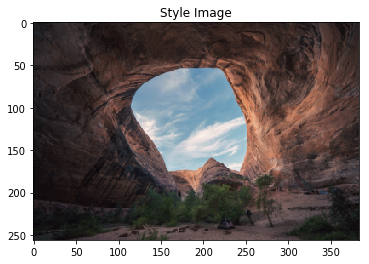

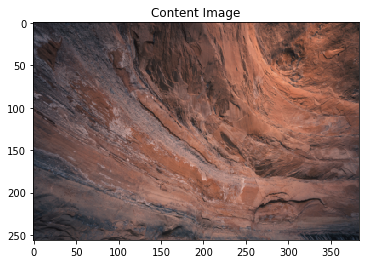

In [35]:
plt.ion()

def imshow(tensor, title=None):
    img = tensor.cpu().clone() #move tensor to from cuda to cpu and clone
    img = unloader(img.squeeze(0)) # remove fake batch dim and unload
    plt.imshow(img) #show image
    if title is not None: #if there's a title
        plt.title(title) #disp title
    plt.pause(0.001)
    
plt.figure()
imshow(styleImg, title='Style Image')
plt.figure()
imshow(contentImg, title='Content Image')

In [36]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__() #call super
        self.target = target.detach() #detach from gradient tree
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) #calc MSE loss
        return input

In [37]:
def gram(input):
    d1, d2, d3, d4 = input.size() 
    #d1 = batch aka 1
    #d2 = number of feature maps
    #d3 = feature map x dim
    #d4 = feature map y dim
    
    features = input.view(d1*d2, d3*d4) #aka reshape to # maps by vectorized map
    G = torch.mm(features, features.t()) # compute gram, end with d2xd2 
    
    return G.div(d1*d2*d3*d4) #normalize by # elements

In [38]:
class StyleLoss(nn.Module):
    def __init__(self, targetFeature):
        super(StyleLoss, self).__init__() # call super
        self.target = gram(targetFeature).detach() 
        
    def forward(self, input):
        G = gram(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

In [39]:
#import VGGnet
cnn = models.vgg19(pretrained=True).features.to(device).eval()
#use features bc want convnet
#use eval for eval mode

#VGG networks are trained on images with each channel normalized by 
# mean=[0.485, 0.456, 0.406] and 
# std=[0.229, 0.224, 0.225].
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [40]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        #reshape so we can broadcast
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

In [41]:
#create a new Sequential module, 
# inserting our content and style loss layers in the right places

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn) #why?
    norm = Normalization(normalization_mean, normalization_std).to(device)
    
    # create list of styles
    content_losses = []
    style_losses = []
    
    #create a new nn.Sequential
    model = nn.Sequential(norm) #first layer - normalize input
    
    
    #purpose: parse through the cnn and recreate the net, but add our own layers
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        print(i)
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            content_layers.remove(name)
            
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            style_layers.remove(name)
            
        # now we trim off the layers after the last content and style losses
        if not style_layers:
            if not content_layers:
                break
            #if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                #break

    #model = model[:(i + 1)]
    print(style_losses)
    print(content_losses)
    return model, style_losses, content_losses
    

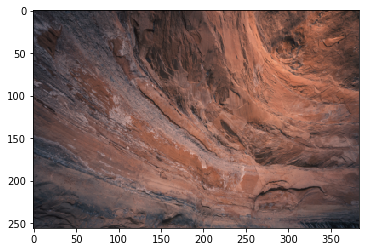

In [42]:
inputImg = contentImg.clone()
#inputImg = torch.randn(contentImg.data.size(), device=device)

plt.figure()
imshow(inputImg)

In [43]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [44]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, styleImg, contentImg)
    optimizer = get_input_optimizer(inputImg)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            inputImg.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    inputImg.data.clamp_(0, 1)

    return inputImg

Building the style transfer model..
0
1
1
2
2
2
3
3
4
4
4
[StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()]
[ContentLoss()]
Optimizing..
run [50]:
Style Loss : 36.647987 Content Loss: 6.851947

run [100]:
Style Loss : 19.578382 Content Loss: 5.918501

run [150]:
Style Loss : 11.101007 Content Loss: 5.412634

run [200]:
Style Loss : 6.933579 Content Loss: 4.708978

run [250]:
Style Loss : 4.767426 Content Loss: 4.231308

run [300]:
Style Loss : 3.550597 Content Loss: 3.885458



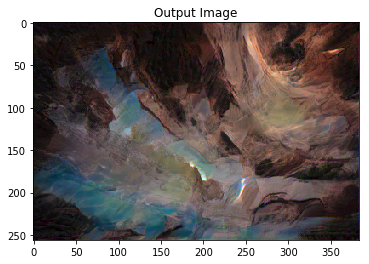

In [45]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            contentImg, styleImg, inputImg)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()